## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.3, 0.5, 0.7, 0.9]
redice_lr_patient = [5, 10, 20, 30]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0912 12:13:30.415710  2340 deprecation_wrapper.py:119] From D:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0912 12:13:30.417710  2340 deprecation_wrapper.py:119] From D:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0912 12:13:30.420710  2340 deprecation_wrapper.py:119] From D:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0912 12:13:30.491710  2340 deprecation_wrapper.py:119] From D:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 5


W0912 12:13:30.707710  2340 deprecation_wrapper.py:119] From D:\Program Files\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0912 12:13:30.715710  2340 deprecation_wrapper.py:119] From D:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0912 12:13:30.791710  2340 deprecation.py:323] From D:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 3s 69us/step - loss: 1.2455 - acc: 0.5665 - val_loss: 1.4777 - val_acc: 0.4807
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2263 - acc: 0.5763 - val_loss: 1.4729 - val_acc: 0.4842
Epoch 16/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2069 - acc: 0.5838 - val_loss: 1.4726 - val_acc: 0.4798
Epoch 17/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.1870 - acc: 0.5909 - val_loss: 1.4575 - val_acc: 0.4877
Epoch 18/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1680 - acc: 0.5980 - val_loss: 1.4652 - val_acc: 0.4826
Epoch 19/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1504 - acc: 0.6041 - val_loss: 1.4528 - val_acc: 0.4877
Epoch 20/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1320 - acc: 0.6108 - val_loss: 1.4579 - val_acc: 0.4878
Epoch 21/25
50000/50000 [=====================

Epoch 2/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.7648 - acc: 0.3848 - val_loss: 1.8066 - val_acc: 0.3791
Epoch 3/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.6380 - acc: 0.4259 - val_loss: 1.6952 - val_acc: 0.4048
Epoch 4/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.5610 - acc: 0.4525 - val_loss: 1.6445 - val_acc: 0.4318
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5069 - acc: 0.4727 - val_loss: 1.6045 - val_acc: 0.4374
Epoch 6/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.4627 - acc: 0.4886 - val_loss: 1.5866 - val_acc: 0.4430
Epoch 7/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4265 - acc: 0.5017 - val_loss: 1.5583 - val_acc: 0.4514
Epoch 8/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.3947 - acc: 0.5117 - val_loss: 1.5458 - val_acc: 0.4575
Epoch 9/25
50000/50000 [=================

50000/50000 [==============================] - 3s 56us/step - loss: 1.0378 - acc: 0.6438 - val_loss: 1.4514 - val_acc: 0.4946
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)  

Epoch 13/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2746 - acc: 0.5575 - val_loss: 1.4740 - val_acc: 0.4889
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2537 - acc: 0.5653 - val_loss: 1.4794 - val_acc: 0.4862
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2342 - acc: 0.5725 - val_loss: 1.4642 - val_acc: 0.4875
Epoch 16/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.2135 - acc: 0.5807 - val_loss: 1.4579 - val_acc: 0.4928
Epoch 17/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1946 - acc: 0.5870 - val_loss: 1.4553 - val_acc: 0.4908
Epoch 18/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1750 - acc: 0.5946 - val_loss: 1.4527 - val_acc: 0.4922
Epoch 19/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1564 - acc: 0.6026 - val_loss: 1.4534 - val_acc: 0.4972
Epoch 20/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 77us/step - loss: 2.2225 - acc: 0.2675 - val_loss: 2.2019 - val_acc: 0.3119
Epoch 2/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.7573 - acc: 0.3854 - val_loss: 1.8743 - val_acc: 0.3751
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.6307 - acc: 0.4263 - val_loss: 1.7142 - val_acc: 0.4118
Epoch 4/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5615 - acc: 0.4515 - val_loss: 1.6539 - val_acc: 0.4185
Epoch 5/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.5083 - acc: 0.4720 - val_loss: 1.6075 - val_acc: 0.4409
Epoch 6/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4644 - acc: 0.4854 - val_loss: 1.5807 - val_acc: 0.4449
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4281 - acc: 0.5003 - val_loss: 1.5605 - val_acc

50000/50000 [==============================] - 3s 56us/step - loss: 1.0710 - acc: 0.6331 - val_loss: 1.4603 - val_acc: 0.4868
Epoch 25/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.0553 - acc: 0.6388 - val_loss: 1.4535 - val_acc: 0.4919
Numbers of exp: 10, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.2877 - acc: 0.5514 - val_loss: 1.4894 - val_acc: 0.4801
Epoch 13/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2643 - acc: 0.5609 - val_loss: 1.4791 - val_acc: 0.4787
Epoch 14/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2438 - acc: 0.5675 - val_loss: 1.4722 - val_acc: 0.4826
Epoch 15/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2204 - acc: 0.5775 - val_loss: 1.4641 - val_acc: 0.4833
Epoch 16/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2021 - acc: 0.5826 - val_loss: 1.4681 - val_acc: 0.4853
Epoch 17/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1825 - acc: 0.5906 - val_loss: 1.4541 - val_acc: 0.4848
Epoch 18/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.1627 - acc: 0.5986 - val_loss: 1.4563 - val_acc: 0.4886
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 95us/step - loss: 2.2050 - acc: 0.2711 - val_loss: 2.1947 - val_acc: 0.3029
Epoch 2/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.7459 - acc: 0.3891 - val_loss: 1.8399 - val_acc: 0.3761
Epoch 3/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.6282 - acc: 0.4306 - val_loss: 1.7261 - val_acc: 0.3995
Epoch 4/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.5559 - acc: 0.4541 - val_loss: 1.6406 - val_acc: 0.4234
Epoch 5/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.5050 - acc: 0.4718 - val_loss: 1.6080 - val_acc: 0.4350
Epoch 6/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.4598 - acc: 0.4867 - val_loss: 1.5729 - val_acc: 0.4477
Epoch 7/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.4220 - acc: 0.5004 - val_loss: 1.5546 - val_acc

50000/50000 [==============================] - 3s 57us/step - loss: 1.0644 - acc: 0.6375 - val_loss: 1.4417 - val_acc: 0.4941
Epoch 25/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.0489 - acc: 0.6418 - val_loss: 1.4388 - val_acc: 0.4928
Numbers of exp: 15, reduce_factor: 0.70, reduce_patient: 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.2878 - acc: 0.5519 - val_loss: 1.4869 - val_acc: 0.4805
Epoch 13/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.2658 - acc: 0.5606 - val_loss: 1.4815 - val_acc: 0.4823
Epoch 14/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.2455 - acc: 0.5708 - val_loss: 1.4620 - val_acc: 0.4918
Epoch 15/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2239 - acc: 0.5775 - val_loss: 1.4662 - val_acc: 0.4934
Epoch 16/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2045 - acc: 0.5827 - val_loss: 1.4621 - val_acc: 0.4901
Epoch 17/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.1848 - acc: 0.5909 - val_loss: 1.4510 - val_acc: 0.4943
Epoch 18/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.1663 - acc: 0.5998 - val_loss: 1.4556 - val_acc: 0.4934
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 98us/step - loss: 2.2416 - acc: 0.2680 - val_loss: 2.2659 - val_acc: 0.2739
Epoch 2/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.7805 - acc: 0.3823 - val_loss: 1.8684 - val_acc: 0.3676
Epoch 3/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.6460 - acc: 0.4272 - val_loss: 1.7455 - val_acc: 0.4061
Epoch 4/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.5679 - acc: 0.4528 - val_loss: 1.6528 - val_acc: 0.4215
Epoch 5/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.5137 - acc: 0.4711 - val_loss: 1.6117 - val_acc: 0.4375
Epoch 6/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4677 - acc: 0.4893 - val_loss: 1.5714 - val_acc: 0.4444
Epoch 7/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4292 - acc: 0.5026 - val_loss: 1.5638 - val_acc

50000/50000 [==============================] - 3s 59us/step - loss: 1.0519 - acc: 0.6418 - val_loss: 1.4364 - val_acc: 0.4978
Epoch 25/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.0368 - acc: 0.6458 - val_loss: 1.4436 - val_acc: 0.4922
Numbers of exp: 20, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_61 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizati

50000/50000 [==============================] - 3s 66us/step - loss: 2.2005 - acc: 0.2719 - val_loss: 2.1926 - val_acc: 0.2682
Epoch 10/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.1802 - acc: 0.2763 - val_loss: 2.1735 - val_acc: 0.2729
Epoch 11/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.1602 - acc: 0.2820 - val_loss: 2.1561 - val_acc: 0.2786
Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.1424 - acc: 0.2869 - val_loss: 2.1401 - val_acc: 0.2804
Epoch 13/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.1257 - acc: 0.2914 - val_loss: 2.1252 - val_acc: 0.2853
Epoch 14/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.1106 - acc: 0.2954 - val_loss: 2.1118 - val_acc: 0.2894
Epoch 15/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0965 - acc: 0.2975 - val_loss: 2.0998 - val_acc: 0.2925
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 114us/step - loss: 2.7603 - acc: 0.1421 - val_loss: 2.6300 - val_acc: 0.1776
Epoch 2/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.5153 - acc: 0.1912 - val_loss: 2.4764 - val_acc: 0.2075
Epoch 3/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.4080 - acc: 0.2146 - val_loss: 2.3923 - val_acc: 0.2236
Epoch 4/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.3365 - acc: 0.2333 - val_loss: 2.3333 - val_acc: 0.2409
Epoch 5/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.2850 - acc: 0.2455 - val_loss: 2.2895 - val_acc: 0.2497
Epoch 6/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.2445 - acc: 0.2553 - val_loss: 2.2545 - val_acc: 0.2566
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.2114 - acc: 0.2638 - val_loss: 2.2278 - val_ac

50000/50000 [==============================] - 3s 66us/step - loss: 1.9678 - acc: 0.3285 - val_loss: 2.0116 - val_acc: 0.3169
Epoch 25/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.9597 - acc: 0.3293 - val_loss: 2.0046 - val_acc: 0.3196
Numbers of exp: 25, reduce_factor: 0.30, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_76 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

50000/50000 [==============================] - 3s 65us/step - loss: 2.1312 - acc: 0.2831 - val_loss: 2.1597 - val_acc: 0.2785
Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.1132 - acc: 0.2873 - val_loss: 2.1443 - val_acc: 0.2819
Epoch 13/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0963 - acc: 0.2916 - val_loss: 2.1299 - val_acc: 0.2861
Epoch 14/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.0830 - acc: 0.2955 - val_loss: 2.1170 - val_acc: 0.2900
Epoch 15/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0689 - acc: 0.2990 - val_loss: 2.1038 - val_acc: 0.2936
Epoch 16/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0553 - acc: 0.3035 - val_loss: 2.0923 - val_acc: 0.2958
Epoch 17/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0442 - acc: 0.3048 - val_loss: 2.0818 - val_acc: 0.2992
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 121us/step - loss: 2.8577 - acc: 0.1214 - val_loss: 2.6423 - val_acc: 0.1704
Epoch 2/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.5854 - acc: 0.1739 - val_loss: 2.4992 - val_acc: 0.1987
Epoch 3/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.4645 - acc: 0.2007 - val_loss: 2.4231 - val_acc: 0.2171
Epoch 4/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.3867 - acc: 0.2173 - val_loss: 2.3651 - val_acc: 0.2307
Epoch 5/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.3294 - acc: 0.2310 - val_loss: 2.3202 - val_acc: 0.2391
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.2831 - acc: 0.2426 - val_loss: 2.2822 - val_acc: 0.2465
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.2483 - acc: 0.2510 - val_loss: 2.2505 - val_ac

50000/50000 [==============================] - 3s 66us/step - loss: 1.9475 - acc: 0.3322 - val_loss: 1.9786 - val_acc: 0.3246
Epoch 25/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.9393 - acc: 0.3350 - val_loss: 1.9719 - val_acc: 0.3271
Numbers of exp: 30, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_91 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.1116 - acc: 0.2891 - val_loss: 2.1322 - val_acc: 0.2811
Epoch 13/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.0952 - acc: 0.2936 - val_loss: 2.1164 - val_acc: 0.2853
Epoch 14/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.0802 - acc: 0.2973 - val_loss: 2.1020 - val_acc: 0.2898
Epoch 15/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.0656 - acc: 0.2998 - val_loss: 2.0893 - val_acc: 0.2943 0s - loss: 2.0694 - acc: 0
Epoch 16/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.0523 - acc: 0.3055 - val_loss: 2.0770 - val_acc: 0.2996
Epoch 17/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.0387 - acc: 0.3096 - val_loss: 2.0654 - val_acc: 0.3031
Epoch 18/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.0271 - acc: 0.3125 - val_loss: 2.0549 - val_acc: 0.3055
Epoch 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 132us/step - loss: 2.8270 - acc: 0.1364 - val_loss: 2.7026 - val_acc: 0.1714
Epoch 2/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.5537 - acc: 0.1871 - val_loss: 2.5438 - val_acc: 0.1969
Epoch 3/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.4336 - acc: 0.2122 - val_loss: 2.4480 - val_acc: 0.2146
Epoch 4/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.3589 - acc: 0.2275 - val_loss: 2.3805 - val_acc: 0.2260
Epoch 5/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.3044 - acc: 0.2386 - val_loss: 2.3317 - val_acc: 0.2338
Epoch 6/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.2608 - acc: 0.2501 - val_loss: 2.2915 - val_acc: 0.2422
Epoch 7/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.2239 - acc: 0.2575 - val_loss: 2.2578 - val_ac

50000/50000 [==============================] - 3s 66us/step - loss: 1.9356 - acc: 0.3343 - val_loss: 1.9762 - val_acc: 0.3251
Epoch 25/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.9276 - acc: 0.3354 - val_loss: 1.9694 - val_acc: 0.3265
Numbers of exp: 35, reduce_factor: 0.70, reduce_patient: 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_106 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.1225 - acc: 0.2824 - val_loss: 2.1434 - val_acc: 0.2783
Epoch 13/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.1047 - acc: 0.2874 - val_loss: 2.1277 - val_acc: 0.2803
Epoch 14/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.0894 - acc: 0.2910 - val_loss: 2.1127 - val_acc: 0.2852
Epoch 15/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.0745 - acc: 0.2966 - val_loss: 2.1000 - val_acc: 0.2883
Epoch 16/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.0618 - acc: 0.2991 - val_loss: 2.0875 - val_acc: 0.2933
Epoch 17/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.0482 - acc: 0.3035 - val_loss: 2.0760 - val_acc: 0.2956
Epoch 18/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.0348 - acc: 0.3070 - val_loss: 2.0653 - val_acc: 0.2993
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 148us/step - loss: 2.7653 - acc: 0.1476 - val_loss: 2.6559 - val_acc: 0.1893
Epoch 2/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.5136 - acc: 0.1992 - val_loss: 2.5024 - val_acc: 0.2165
Epoch 3/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.4087 - acc: 0.2208 - val_loss: 2.4156 - val_acc: 0.2276
Epoch 4/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.3376 - acc: 0.2361 - val_loss: 2.3563 - val_acc: 0.2412
Epoch 5/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.2869 - acc: 0.2478 - val_loss: 2.3119 - val_acc: 0.2506
Epoch 6/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.2446 - acc: 0.2571 - val_loss: 2.2745 - val_acc: 0.2585
Epoch 7/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.2112 - acc: 0.2658 - val_loss: 2.2439 - val_ac

Epoch 24/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.9797 - acc: 0.3212 - val_loss: 2.0172 - val_acc: 0.3158
Epoch 25/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.9711 - acc: 0.3248 - val_loss: 2.0098 - val_acc: 0.3177
Numbers of exp: 40, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_121 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch

50000/50000 [==============================] - 3s 65us/step - loss: 1.7212 - acc: 0.3997 - val_loss: 1.7970 - val_acc: 0.3791
Epoch 11/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.6953 - acc: 0.4067 - val_loss: 1.7700 - val_acc: 0.3878
Epoch 12/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.6737 - acc: 0.4134 - val_loss: 1.7525 - val_acc: 0.3958
Epoch 13/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.6518 - acc: 0.4226 - val_loss: 1.7381 - val_acc: 0.3986
Epoch 14/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.6317 - acc: 0.4296 - val_loss: 1.7238 - val_acc: 0.4007
Epoch 15/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.6149 - acc: 0.4347 - val_loss: 1.7166 - val_acc: 0.4082
Epoch 16/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.5972 - acc: 0.4408 - val_loss: 1.7061 - val_acc: 0.4122
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 147us/step - loss: 2.5998 - acc: 0.1741 - val_loss: 2.4422 - val_acc: 0.2200
Epoch 2/25
50000/50000 [==============================] - 3s 64us/step - loss: 2.2741 - acc: 0.2506 - val_loss: 2.2634 - val_acc: 0.2652
Epoch 3/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.1158 - acc: 0.2900 - val_loss: 2.1461 - val_acc: 0.2878
Epoch 4/25
50000/50000 [==============================] - 3s 65us/step - loss: 2.0123 - acc: 0.3186 - val_loss: 2.0674 - val_acc: 0.3129
Epoch 5/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.9360 - acc: 0.3386 - val_loss: 2.0001 - val_acc: 0.3237
Epoch 6/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.8787 - acc: 0.3537 - val_loss: 1.9396 - val_acc: 0.3409
Epoch 7/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.8315 - acc: 0.3691 - val_loss: 1.8965 - val_ac

50000/50000 [==============================] - 3s 64us/step - loss: 1.5073 - acc: 0.4740 - val_loss: 1.6338 - val_acc: 0.4298
Epoch 25/25
50000/50000 [==============================] - 3s 64us/step - loss: 1.4959 - acc: 0.4767 - val_loss: 1.6274 - val_acc: 0.4281
Numbers of exp: 45, reduce_factor: 0.30, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_136 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

Epoch 12/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.6813 - acc: 0.4147 - val_loss: 1.7669 - val_acc: 0.3930
Epoch 13/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.6610 - acc: 0.4209 - val_loss: 1.7452 - val_acc: 0.3990
Epoch 14/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.6408 - acc: 0.4297 - val_loss: 1.7311 - val_acc: 0.4015
Epoch 15/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.6224 - acc: 0.4348 - val_loss: 1.7180 - val_acc: 0.4066
Epoch 16/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.6060 - acc: 0.4406 - val_loss: 1.7063 - val_acc: 0.4110
Epoch 17/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.5909 - acc: 0.4470 - val_loss: 1.6999 - val_acc: 0.4122
Epoch 18/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.5746 - acc: 0.4524 - val_loss: 1.6863 - val_acc: 0.4163
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 157us/step - loss: 2.6858 - acc: 0.1686 - val_loss: 2.4811 - val_acc: 0.2245
Epoch 2/25
50000/50000 [==============================] - 3s 62us/step - loss: 2.3028 - acc: 0.2482 - val_loss: 2.2681 - val_acc: 0.2689
Epoch 3/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.1239 - acc: 0.2897 - val_loss: 2.1118 - val_acc: 0.2957
Epoch 4/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.0117 - acc: 0.3188 - val_loss: 2.0231 - val_acc: 0.3198
Epoch 5/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.9316 - acc: 0.3395 - val_loss: 1.9526 - val_acc: 0.3386
Epoch 6/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.8721 - acc: 0.3560 - val_loss: 1.9017 - val_acc: 0.3513
Epoch 7/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.8228 - acc: 0.3710 - val_loss: 1.8629 - val_ac

50000/50000 [==============================] - 3s 65us/step - loss: 1.5009 - acc: 0.4773 - val_loss: 1.6239 - val_acc: 0.4280
Epoch 25/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4899 - acc: 0.4815 - val_loss: 1.6192 - val_acc: 0.4360
Numbers of exp: 50, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_151 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizat

50000/50000 [==============================] - 3s 67us/step - loss: 1.7164 - acc: 0.4043 - val_loss: 1.8107 - val_acc: 0.3783
Epoch 12/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.6930 - acc: 0.4117 - val_loss: 1.7882 - val_acc: 0.3835
Epoch 13/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.6709 - acc: 0.4179 - val_loss: 1.7775 - val_acc: 0.3891
Epoch 14/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.6509 - acc: 0.4257 - val_loss: 1.7573 - val_acc: 0.3915
Epoch 15/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.6317 - acc: 0.4301 - val_loss: 1.7468 - val_acc: 0.3932
Epoch 16/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.6149 - acc: 0.4357 - val_loss: 1.7353 - val_acc: 0.3988
Epoch 17/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5976 - acc: 0.4423 - val_loss: 1.7238 - val_acc: 0.4004
Epoch 18/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 167us/step - loss: 2.6149 - acc: 0.1706 - val_loss: 2.5093 - val_acc: 0.2130
Epoch 2/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.2923 - acc: 0.2421 - val_loss: 2.3066 - val_acc: 0.2489
Epoch 3/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.1280 - acc: 0.2831 - val_loss: 2.1654 - val_acc: 0.2787
Epoch 4/25
50000/50000 [==============================] - 3s 67us/step - loss: 2.0215 - acc: 0.3144 - val_loss: 2.0764 - val_acc: 0.3013
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.9431 - acc: 0.3357 - val_loss: 1.9938 - val_acc: 0.3179
Epoch 6/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.8839 - acc: 0.3517 - val_loss: 1.9425 - val_acc: 0.3354
Epoch 7/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.8358 - acc: 0.3670 - val_loss: 1.9043 - val_ac

50000/50000 [==============================] - 3s 65us/step - loss: 1.5158 - acc: 0.4712 - val_loss: 1.6514 - val_acc: 0.4200
Epoch 24/25
50000/50000 [==============================] - 3s 65us/step - loss: 1.5038 - acc: 0.4754 - val_loss: 1.6437 - val_acc: 0.4202
Epoch 25/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.4948 - acc: 0.4794 - val_loss: 1.6360 - val_acc: 0.4239
Numbers of exp: 55, reduce_factor: 0.70, reduce_patient: 30
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_166 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_lay

50000/50000 [==============================] - 3s 66us/step - loss: 1.7367 - acc: 0.3982 - val_loss: 1.8293 - val_acc: 0.3782
Epoch 11/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.7094 - acc: 0.4058 - val_loss: 1.8082 - val_acc: 0.3809
Epoch 12/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6847 - acc: 0.4154 - val_loss: 1.7876 - val_acc: 0.3910
Epoch 13/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6627 - acc: 0.4219 - val_loss: 1.7689 - val_acc: 0.3959
Epoch 14/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6419 - acc: 0.4292 - val_loss: 1.7526 - val_acc: 0.3991
Epoch 15/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6226 - acc: 0.4341 - val_loss: 1.7399 - val_acc: 0.4038
Epoch 16/25
50000/50000 [==============================] - 3s 66us/step - loss: 1.6063 - acc: 0.4413 - val_loss: 1.7269 - val_acc: 0.4075
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 177us/step - loss: 2.6762 - acc: 0.1657 - val_loss: 2.5115 - val_acc: 0.2125
Epoch 2/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.3002 - acc: 0.2401 - val_loss: 2.2912 - val_acc: 0.2533
Epoch 3/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.1274 - acc: 0.2819 - val_loss: 2.1415 - val_acc: 0.2803
Epoch 4/25
50000/50000 [==============================] - 3s 68us/step - loss: 2.0189 - acc: 0.3111 - val_loss: 2.0676 - val_acc: 0.2996
Epoch 5/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.9412 - acc: 0.3323 - val_loss: 1.9788 - val_acc: 0.3270
Epoch 6/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.8815 - acc: 0.3493 - val_loss: 1.9350 - val_acc: 0.3430
Epoch 7/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.8329 - acc: 0.3651 - val_loss: 1.8884 - val_ac

D:\Program Files\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.581000). Check your callbacks.
  % delta_t_median)
D:\Program Files\Anaconda3\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.291000). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 4s 81us/step - loss: 1.5867 - acc: 0.4444 - val_loss: 1.6924 - val_acc: 0.4094
Epoch 19/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5705 - acc: 0.4514 - val_loss: 1.6797 - val_acc: 0.4096
Epoch 20/25
50000/50000 [==============================] - 3s 70us/step - loss: 1.5567 - acc: 0.4545 - val_loss: 1.6697 - val_acc: 0.4178
Epoch 21/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5438 - acc: 0.4599 - val_loss: 1.6617 - val_acc: 0.4171
Epoch 22/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5310 - acc: 0.4634 - val_loss: 1.6507 - val_acc: 0.4224
Epoch 23/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5185 - acc: 0.4686 - val_loss: 1.6472 - val_acc: 0.4221
Epoch 24/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.5085 - acc: 0.4730 - val_loss: 1.6352 - val_acc: 0.4257
Epoch 25/25
50000/50000 [=====================

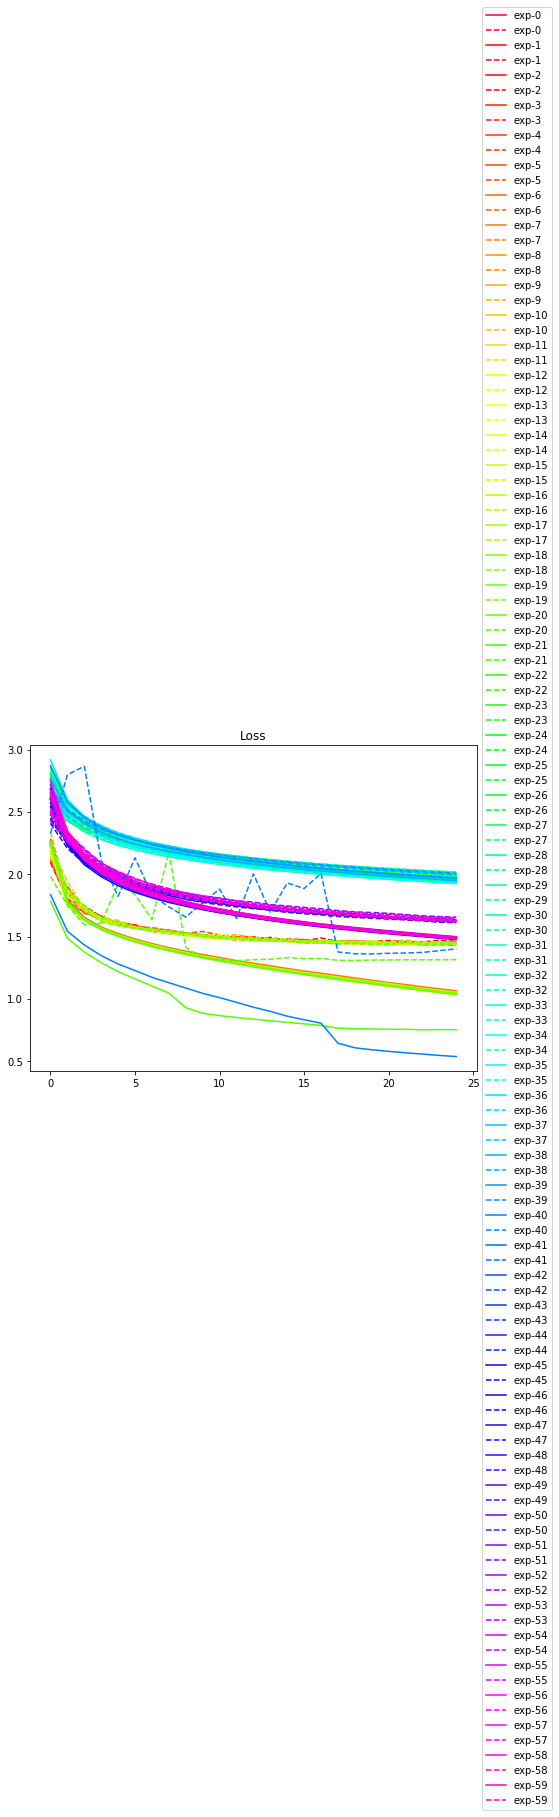

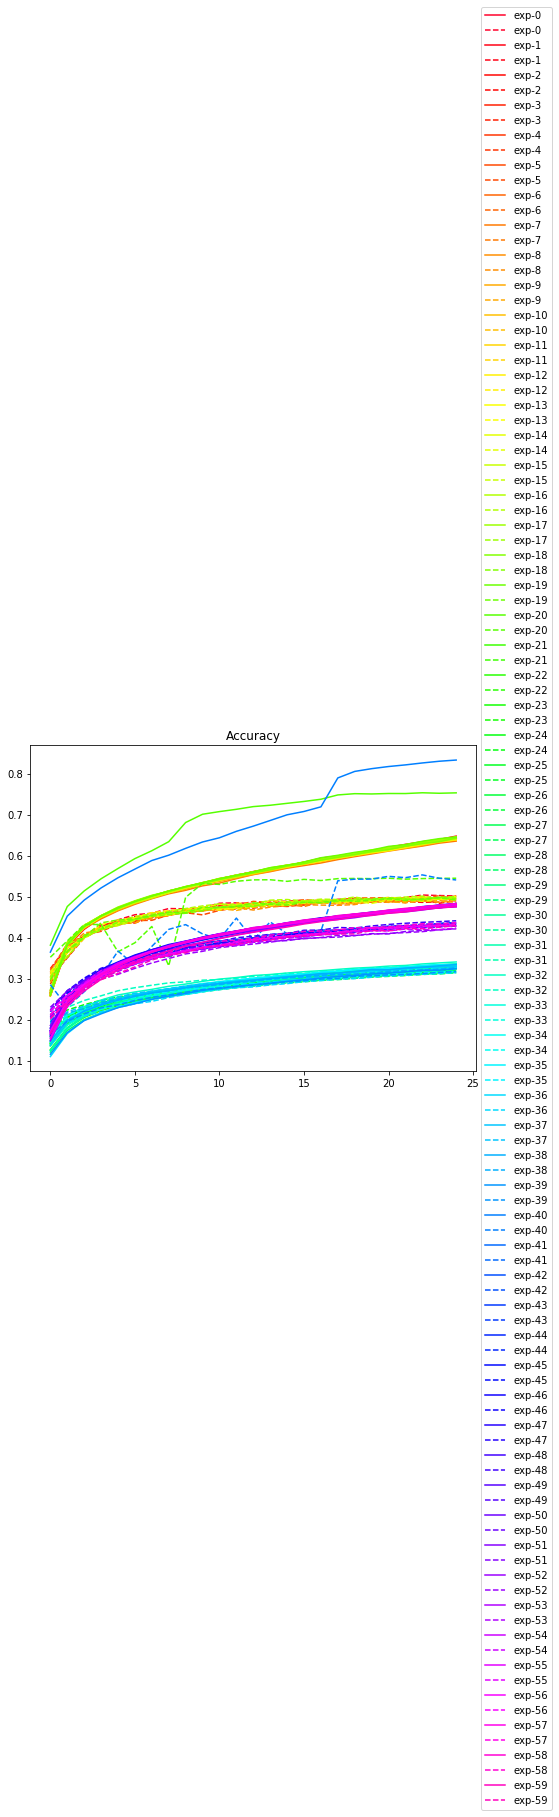

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()